In [49]:
import pathlib
import pickle

from astropy.constants import c as speed_of_light
import astropy.coordinates as coord
from astropy.stats import median_absolute_deviation as MAD
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import gala.coordinates as gc
import scipy.ndimage as scn
import scipy.interpolate as sci
import scipy.optimize as sco

from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import jax.scipy as jsci
import blackjax

from pyia import GaiaData

from astroquery.gaia import Gaia
Gaia.login(credentials_file='/mnt/home/apricewhelan/.gaia/archive.login')

INFO:astroquery:Login to gaia TAP server


INFO: Login to gaia TAP server [astroquery.gaia.core]


INFO:astroquery:Login to gaia data server


OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK


In [50]:
data_path = pathlib.Path('../data').resolve().absolute()
cache_path = pathlib.Path('../cache').resolve().absolute()

In [51]:
with open(cache_path / 'joint-model.pkl', 'rb') as f:
    JointModel, res_pars = pickle.load(f)

In [52]:
run_data = at.Table.read(cache_path / 'run_data.fits')
run_data = {k: np.array(run_data[k]) for k in run_data.colnames}

In [53]:
with open(data_path / 'galcen_frame.pkl', 'rb') as f:
    galcen_frame = pickle.load(f)

In [54]:
g = GaiaData(
    at.join(
        at.Table.read(data_path / 'gd1-GaiaDR3-PS1DR2-joined.fits'),
        at.Table.read(cache_path / 'optimized-member-prob.fits'), 
        keys='source_id'
    )
)

mask = (
    ((g.g0 - g.i0) < 1.) &
    (g.member_prob > 0.01)
)
g = g[mask]
c = g.get_skycoord(distance=False)

len(c)

3878

In [55]:
all_joined = {}
rv_priority = ['gaia', 'hecto', 'apogee', 'segue', 'sdss', 'lamost']

# Survey data

## Gaia

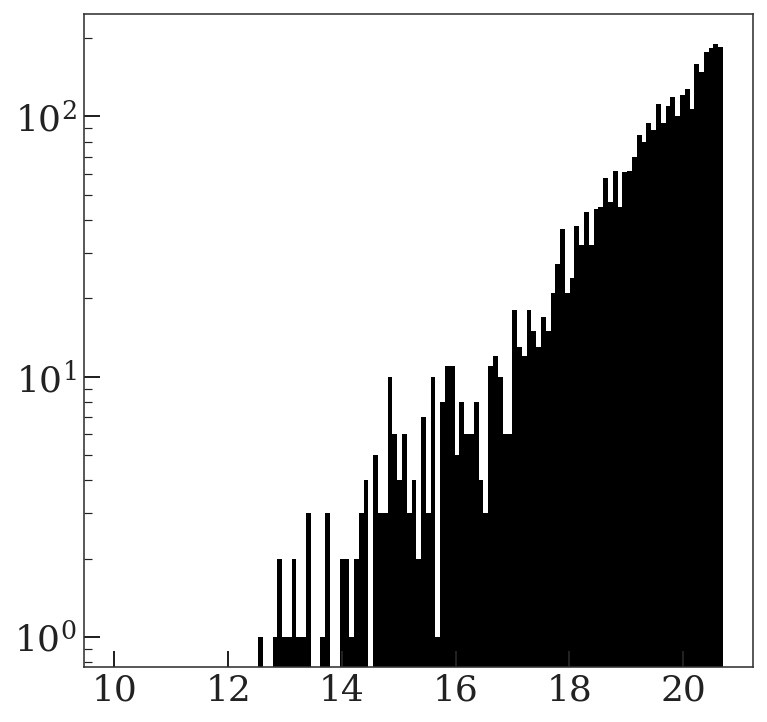

In [56]:
plt.hist(g.phot_g_mean_mag.value, bins=np.linspace(10, 20.7, 128));
plt.yscale('log')

In [57]:
t = g.data['source_id', 'member_prob'][(g.phot_g_mean_mag.value < 18)]
len(t)

439

In [58]:
job = Gaia.launch_job(
    query=("select * from gaiadr3.gaia_source as gaia "
           "JOIN tap_upload.table_test as tt ON tt.source_id = gaia.source_id"),
    upload_resource=t, 
    upload_table_name="table_test", 
    verbose=True
)
gaia_results = job.get_results()

Launched query: 'select  TOP 2000 * from gaiadr3.gaia_source as gaia JOIN tap_upload.table_test as tt ON tt.source_id = gaia.source_id'
------>https
host = gea.esac.esa.int:443
context = /tap-server/tap/sync
Content-type = multipart/form-data; boundary====1665505207235===
200 200
[('Date', 'Tue, 11 Oct 2022 16:20:07 GMT'), ('Server', 'Apache/2.4.6 (CentOS) OpenSSL/1.0.2k-fips mod_jk/1.2.43'), ('Cache-Control', 'no-cache, no-store, max-age=0, must-revalidate'), ('Pragma', 'no-cache'), ('Expires', '0'), ('X-XSS-Protection', '1; mode=block'), ('X-Frame-Options', 'SAMEORIGIN'), ('X-Content-Type-Options', 'nosniff'), ('Content-Encoding', 'gzip'), ('Content-Disposition', 'attachment;filename="1665505207622O-result.vot"'), ('Transfer-Encoding', 'chunked'), ('Content-Type', 'application/x-votable+xml')]
Retrieving sync. results...
Query finished.


In [59]:
gaia_joined = at.join(
    g.data[['gd1_phi1', 'gd1_phi2', 'source_id']], 
    gaia_results,
    keys='source_id'
)
gaia_joined = gaia_joined[np.isfinite(gaia_joined['radial_velocity'])]
gaia_joined['gd1_rv'] = gaia_joined['radial_velocity']
gaia_joined['gd1_rv_err'] = gaia_joined['radial_velocity_error']
all_joined['gaia'] = gaia_joined

(-450.0, 400.0)

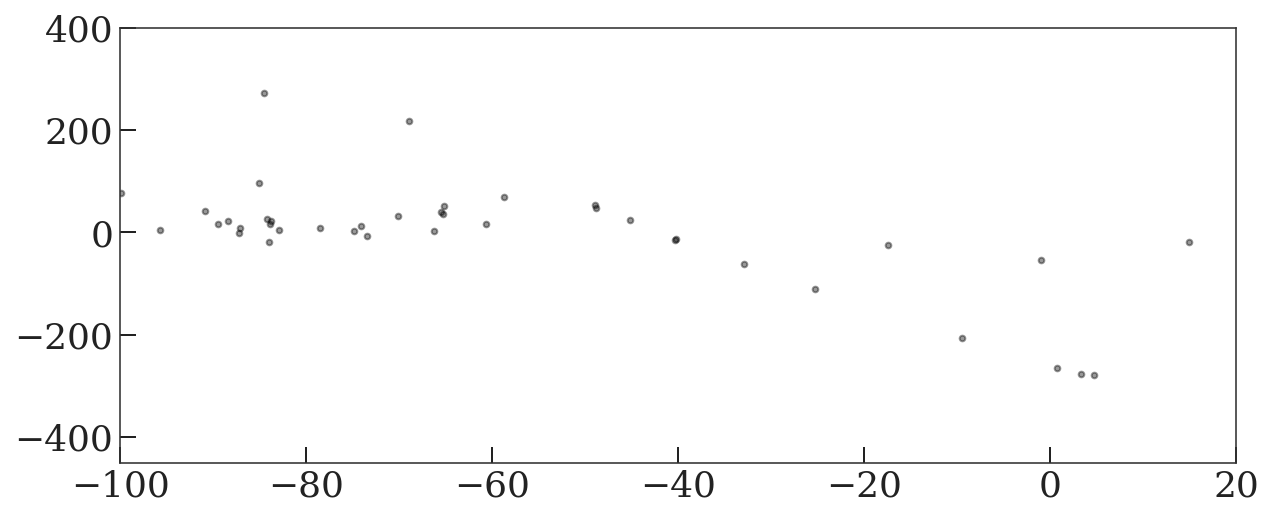

In [60]:
plt.figure(figsize=(10, 4))
plt.scatter(gaia_joined['gd1_phi1'], gaia_joined['radial_velocity'], alpha=0.4, s=8)
plt.xlim(-100, 20)
plt.ylim(-450, 400)

(-500.0, 400.0)

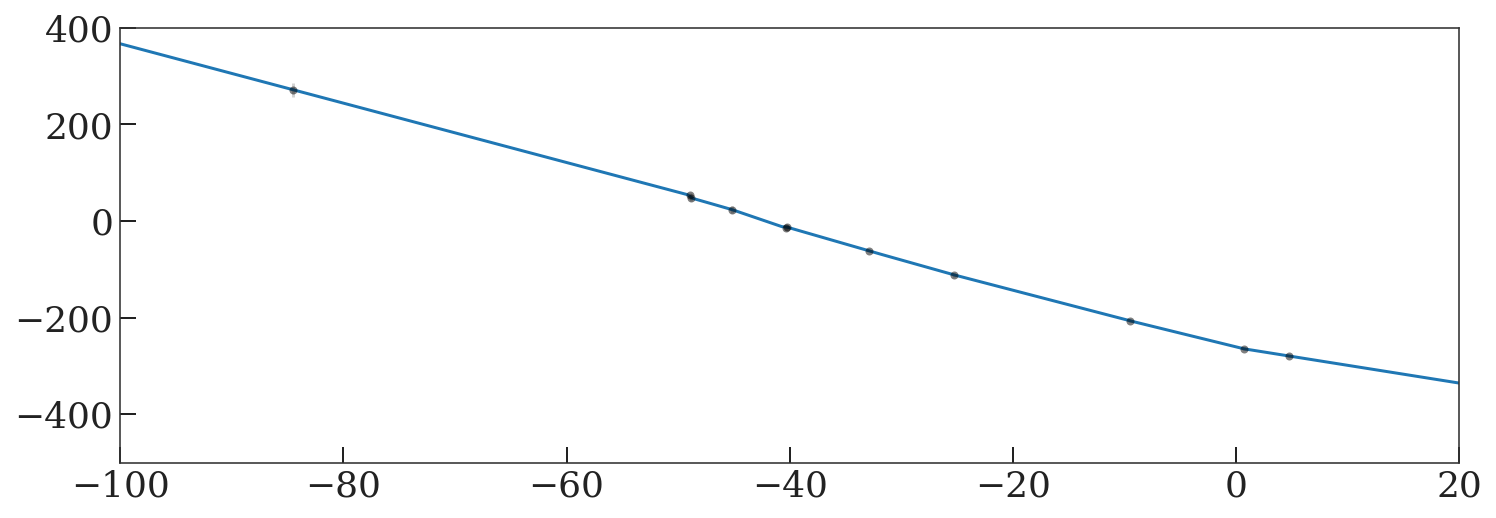

In [61]:
_strict = (
    (gaia_joined['member_prob'] > 0.9) &
    ((gaia_joined['gd1_phi1'] > -55) | 
     (gaia_joined['gd1_phi1'] <= -55) & (gaia_joined['gd1_rv'] > 80))
)

x = gaia_joined['gd1_phi1'][_strict]
y = gaia_joined['gd1_rv'][_strict]
yerr = gaia_joined['gd1_rv_err'][_strict]
fiducial_spl = sci.InterpolatedUnivariateSpline(
    x[np.argsort(x)],
    y[np.argsort(x)],
    k=1,
    w=1/yerr[np.argsort(x)]**2
)
with open(cache_path / 'fiducial_rv_spline.pkl', 'wb') as f:
    pickle.dump(fiducial_spl, f)

fig, ax = plt.subplots(figsize=(12, 4))
ax.errorbar(
    gaia_joined['gd1_phi1'][_strict],
    gaia_joined['gd1_rv'][_strict],
    gaia_joined['gd1_rv_err'][_strict],
    ls='none',
    marker='o',
    ecolor='#aaaaaa',
    alpha=0.5,
    ms=4
)

_grid = np.linspace(-100, 20, 256)
ax.plot(_grid, fiducial_spl(_grid), marker='')
ax.set_xlim(-100, 20)
ax.set_ylim(-500, 400)

## APOGEE

In [62]:
allstar = at.Table.read('/mnt/home/apricewhelan/data/APOGEE_DR17/allStarLite-dr17-synspec_rev1.fits')
allstar_c = coord.SkyCoord(
    allstar['RA'][np.isfinite(allstar['RA'])], 
    allstar['DEC'][np.isfinite(allstar['RA'])], 
    unit=u.deg
)

In [63]:
ap_idx, ap_sep, _ = c.match_to_catalog_sky(allstar_c)
sep_mask = (ap_sep < 2*u.arcsec)
apogee_joined = at.hstack((g.data[sep_mask], allstar[ap_idx[sep_mask]]))
apogee_joined = apogee_joined[np.isfinite(apogee_joined['VHELIO_AVG'])]
apogee_joined['gd1_rv'] = apogee_joined['VHELIO_AVG']
apogee_joined['gd1_rv_err'] = apogee_joined['VERR']
all_joined['apogee'] = apogee_joined

(-450.0, 400.0)

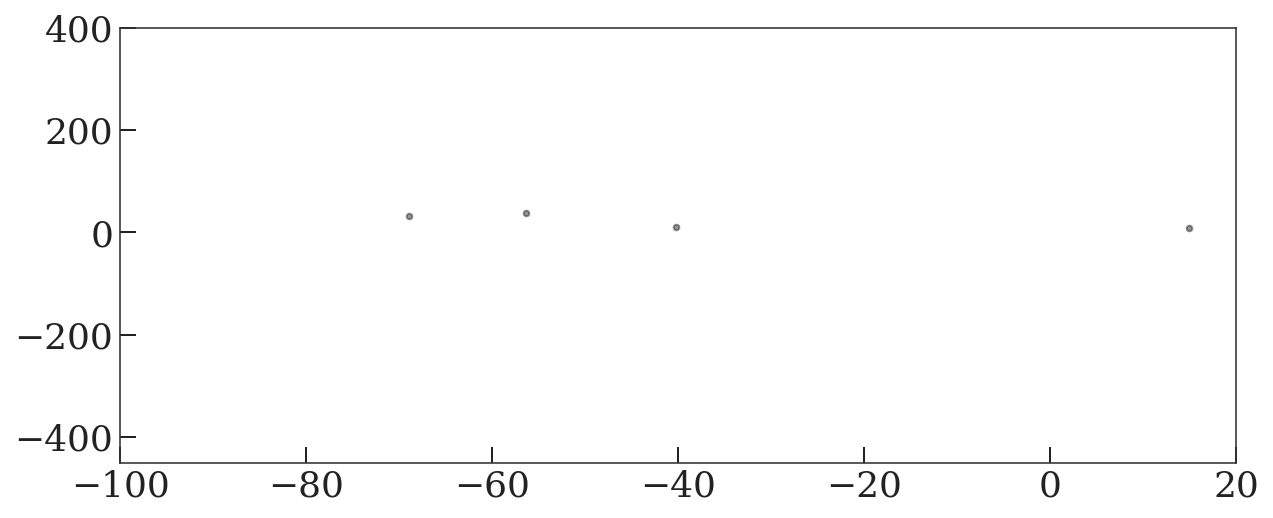

In [64]:
plt.figure(figsize=(10, 4))
plt.scatter(apogee_joined['gd1_phi1'], apogee_joined['VHELIO_AVG'], alpha=0.4, s=8)
plt.xlim(-100, 20)
plt.ylim(-450, 400)

## SDSS/BOSS

In [65]:
sdss = at.Table.read('/mnt/home/apricewhelan/data/sdss/specObjAll-STAR.fits')
sdss['rv'] = speed_of_light.to(u.km/u.s) * sdss['z']
sdss['rv_err'] = speed_of_light.to(u.km/u.s) * sdss['zErr']

In [66]:
sdss_c = coord.SkyCoord(sdss['ra']*u.deg, sdss['dec']*u.deg)

In [67]:
sdss_idx, sdss_sep, _ = c.match_to_catalog_sky(sdss_c)
sep_mask = (sdss_sep < 2*u.arcsec)
sdss_joined = at.hstack((g.data[sep_mask], sdss[sdss_idx[sep_mask]]), 
                        uniq_col_name='{col_name}{table_name}',
                        table_names=['_segue', ''])
sdss_joined = sdss_joined[np.isfinite(sdss_joined['rv'])]
sdss_joined['gd1_rv'] = sdss_joined['rv']
sdss_joined['gd1_rv_err'] = sdss_joined['rv_err']
all_joined['sdss'] = sdss_joined

(-450.0, 400.0)

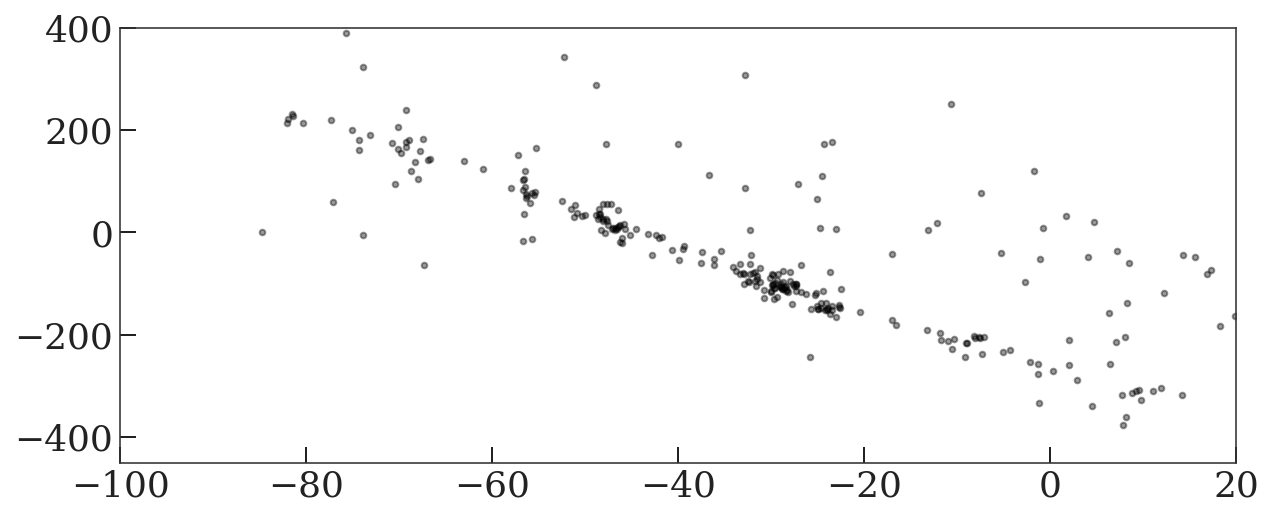

In [68]:
plt.figure(figsize=(10, 4))
plt.scatter(sdss_joined['gd1_phi1'], sdss_joined['rv'], alpha=0.4, s=8)
plt.xlim(-100, 20)
plt.ylim(-450, 400)

## SEGUE

In [69]:
segue = at.Table.read('/mnt/home/apricewhelan/data/SEGUE/SEGUE-EDR3-xmatch-full.fits')

In [70]:
segue_joined = at.join(segue, g.data, keys='source_id', 
                       uniq_col_name='{col_name}{table_name}',
                       table_names=['_segue', ''])
segue_joined = segue_joined[np.isfinite(segue_joined['RV_ADOP'])]
segue_joined['gd1_rv'] = segue_joined['RV_ADOP']
segue_joined['gd1_rv_err'] = 5.  # ??
all_joined['segue'] = segue_joined

(-450.0, 400.0)

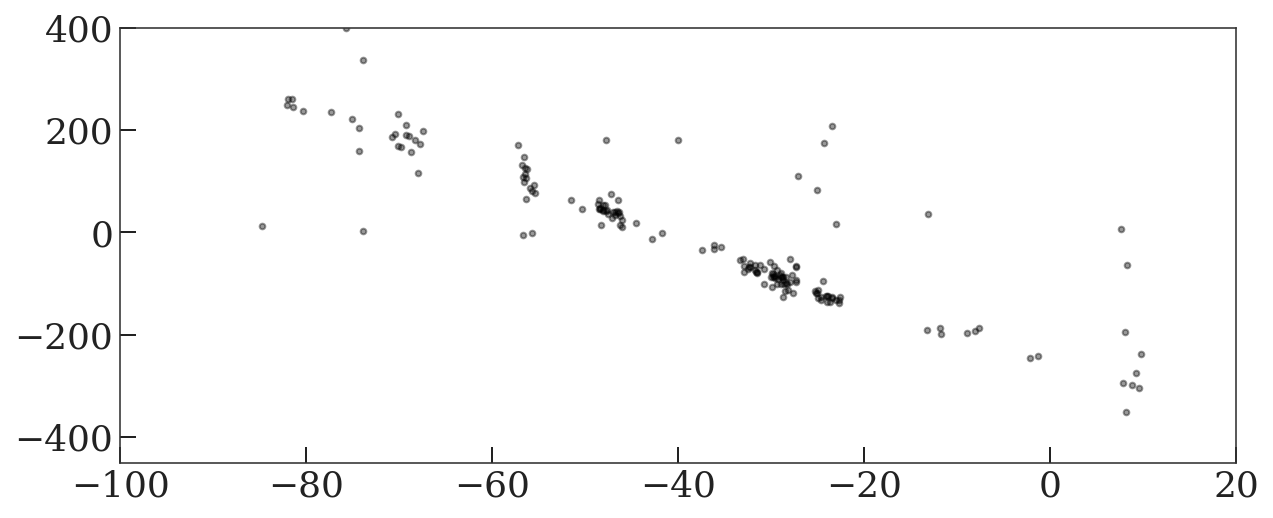

In [71]:
plt.figure(figsize=(10, 4))
plt.scatter(segue_joined['gd1_phi1'], segue_joined['gd1_rv'], alpha=0.4, s=8)
plt.xlim(-100, 20)
plt.ylim(-450, 400)

## LAMOST

In [72]:
lamost = at.Table.read('/mnt/home/apricewhelan/data/LAMOST/DDPayne_LAMOST-DR5_recommend.fits')

In [73]:
lamost_c = coord.SkyCoord(lamost['RA'], lamost['DEC'], unit=u.deg)

In [74]:
lamost_idx, lamost_sep, _ = c.match_to_catalog_sky(lamost_c)
sep_mask = (lamost_sep < 2*u.arcsec)
lamost_joined = at.hstack((g.data[sep_mask], lamost[lamost_idx[sep_mask]]))
lamost_joined = lamost_joined[np.isfinite(lamost_joined['RV'])]
lamost_joined['gd1_rv'] = lamost_joined['RV']
lamost_joined['gd1_rv_err'] = lamost_joined['RV_ERR']
all_joined['lamost'] = lamost_joined

(-450.0, 400.0)

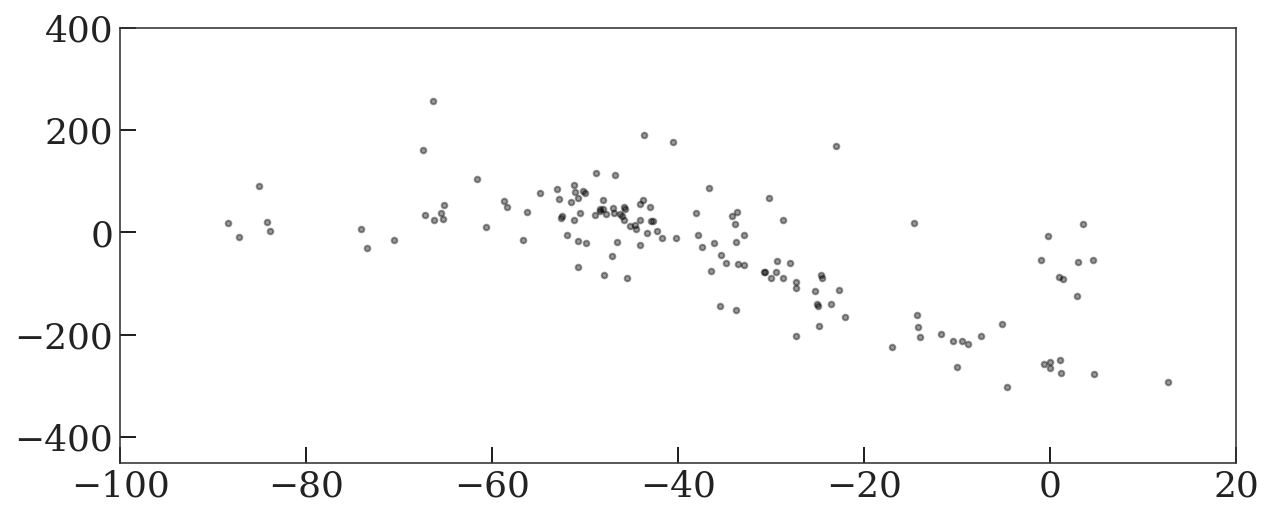

In [75]:
plt.figure(figsize=(10, 4))
plt.scatter(lamost_joined['gd1_phi1'], lamost_joined['RV'], alpha=0.4, s=8)
plt.xlim(-100, 20)
plt.ylim(-450, 400)

## Hectospec

In [76]:
hecto = at.Table.read('../data/hecto-catalog.fits')

In [77]:
hecto_c = coord.SkyCoord(hecto['ra'], hecto['dec'], unit=u.deg)

In [78]:
hecto_idx, hecto_sep, _ = c.match_to_catalog_sky(hecto_c)
sep_mask = (hecto_sep < 2*u.arcsec)
hecto_joined = at.hstack(
    (g.data[sep_mask], hecto[hecto_idx[sep_mask]]),
    uniq_col_name='{col_name}{table_name}',
    table_names=['', '_2']
)
hecto_joined = hecto_joined[np.isfinite(hecto_joined['Vrad'])]
hecto_joined['gd1_rv'] = hecto_joined['Vrad']
hecto_joined['gd1_rv_err'] = hecto_joined['std_Vrad']
all_joined['hecto'] = hecto_joined

(-450.0, 400.0)

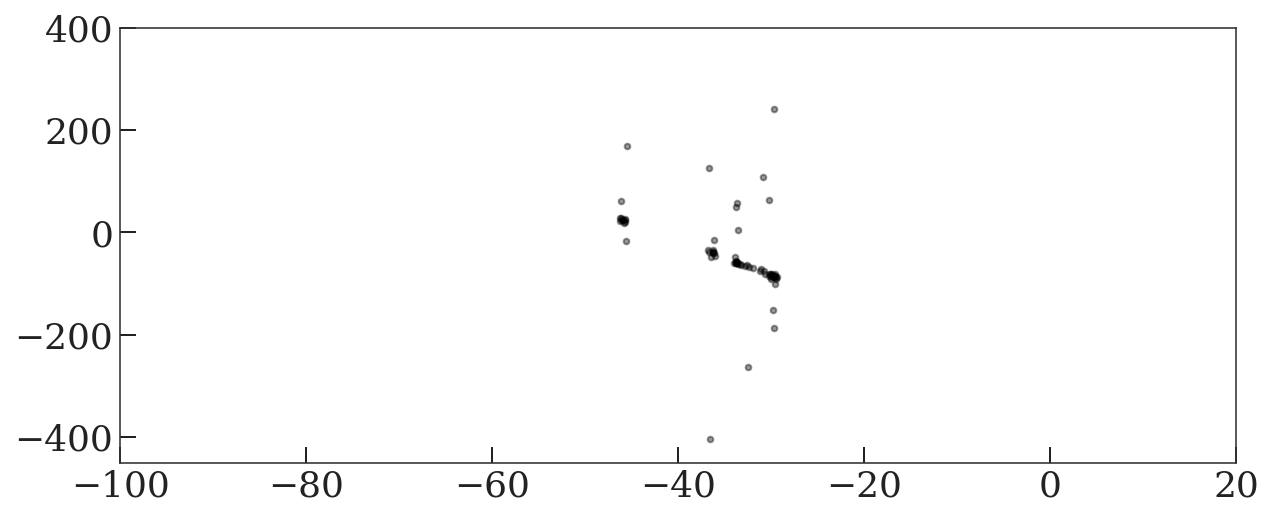

In [79]:
plt.figure(figsize=(10, 4))
plt.scatter(hecto_joined['gd1_phi1'], hecto_joined['Vrad'], alpha=0.4, s=8)
plt.xlim(-100, 20)
plt.ylim(-450, 400)

## All combined

In [80]:
for i, name in enumerate(all_joined.keys()):
    all_joined[name]['survey_id'] = i
    all_joined[name]['survey_name'] = name

In [81]:
all_stacked = at.vstack(list(all_joined.values()))
assert np.isfinite(all_stacked['gd1_rv']).all()
len(all_stacked)

704

In [82]:
remove_cols = []
for name in all_stacked.colnames:
    if all_stacked[name].dtype == np.dtype('O'):
        remove_cols.append(name)
all_stacked.remove_columns(remove_cols)

In [83]:
c = coord.SkyCoord(
    all_stacked['gd1_phi1'], 
    all_stacked['gd1_phi2'], 
    unit=u.deg, 
    frame=gc.GD1Koposov10()
)
vgsr = gc.vhel_to_vgsr(c, all_stacked['gd1_rv'], galcen_frame.galcen_v_sun.d_xyz)
all_stacked['v_gsr'] = vgsr

In [84]:
all_stacked.write(data_path / 'gd1-all-spectro-data.fits', overwrite=True)

In [87]:
np.unique(all_stacked['source_id']).size

436

(-500.0, 500.0)

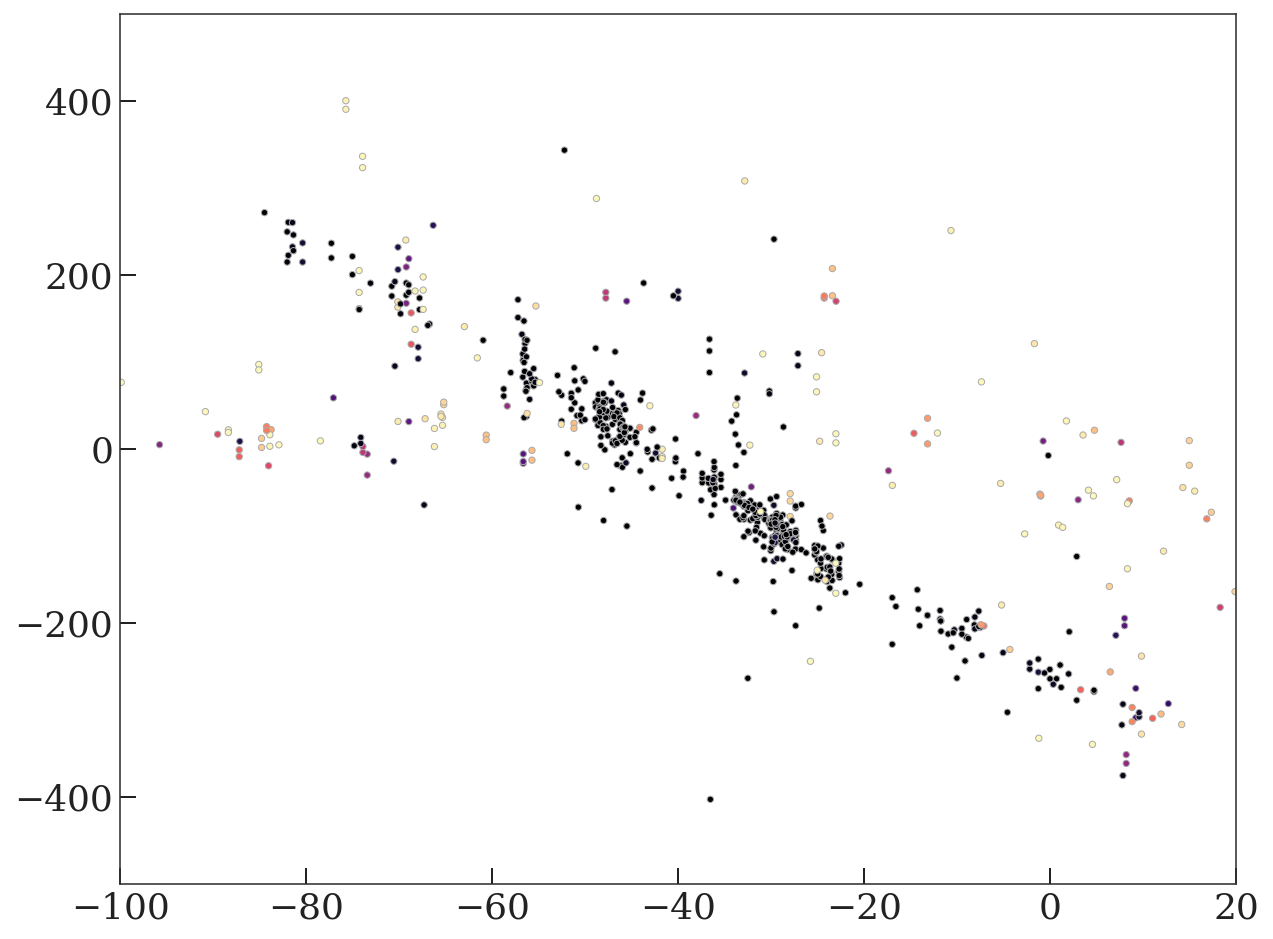

In [88]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(
    all_stacked['gd1_phi1'],
    all_stacked['gd1_rv'],
    c=all_stacked['member_prob'],
    vmin=0, 
    vmax=1,
    cmap='magma_r',
    s=10,
    linewidth=0.5, edgecolor='#aaaaaa'
)
ax.set_xlim(-100, 20)
ax.set_ylim(-500, 500)

(-500.0, 500.0)

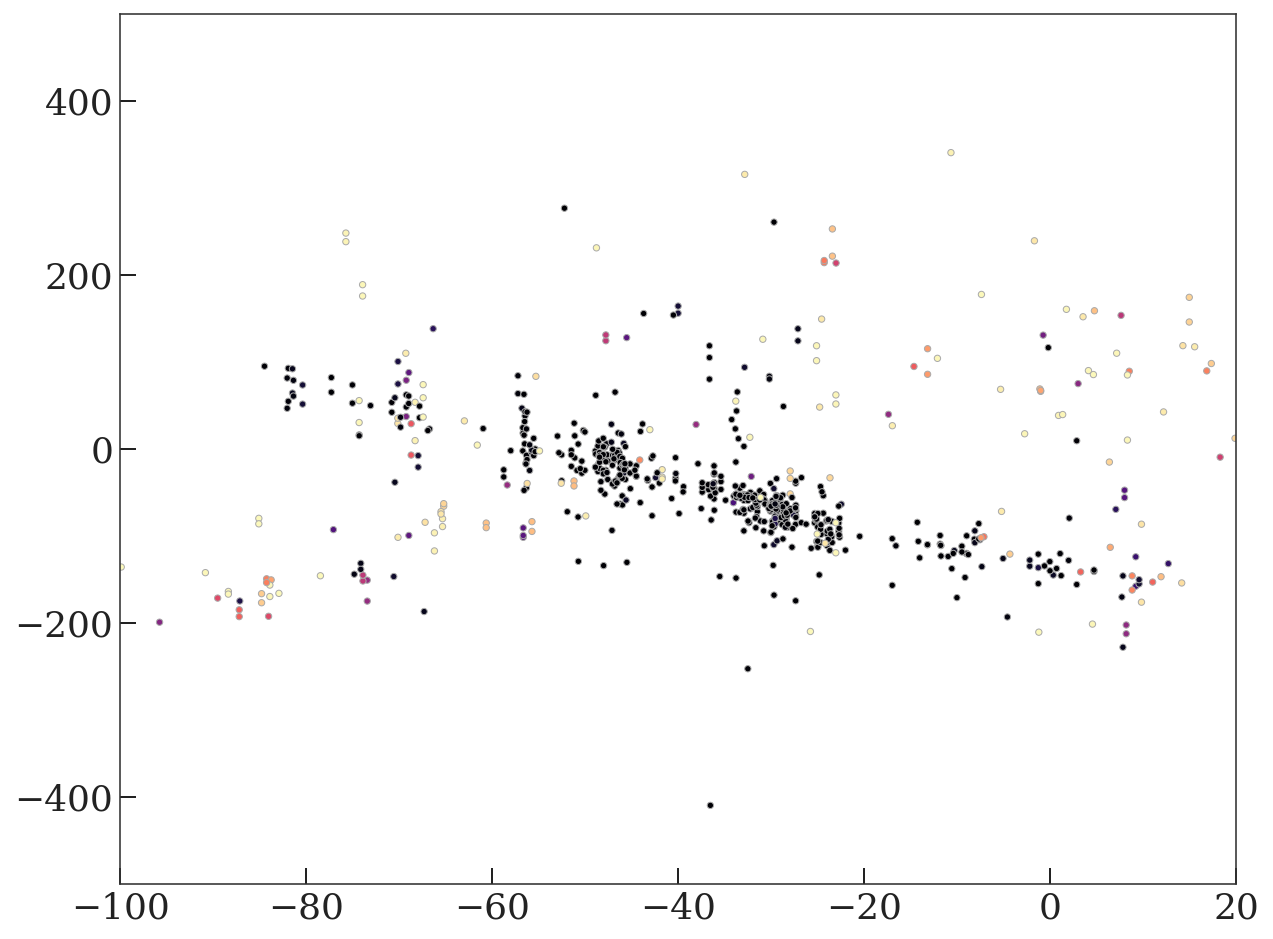

In [89]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(
    all_stacked['gd1_phi1'],
    all_stacked['v_gsr'],
    c=all_stacked['member_prob'],
    vmin=0, 
    vmax=1,
    cmap='magma_r',
    s=10,
    linewidth=0.5, edgecolor='#aaaaaa'
)
ax.set_xlim(-100, 20)
ax.set_ylim(-500, 500)

(-500.0, 400.0)

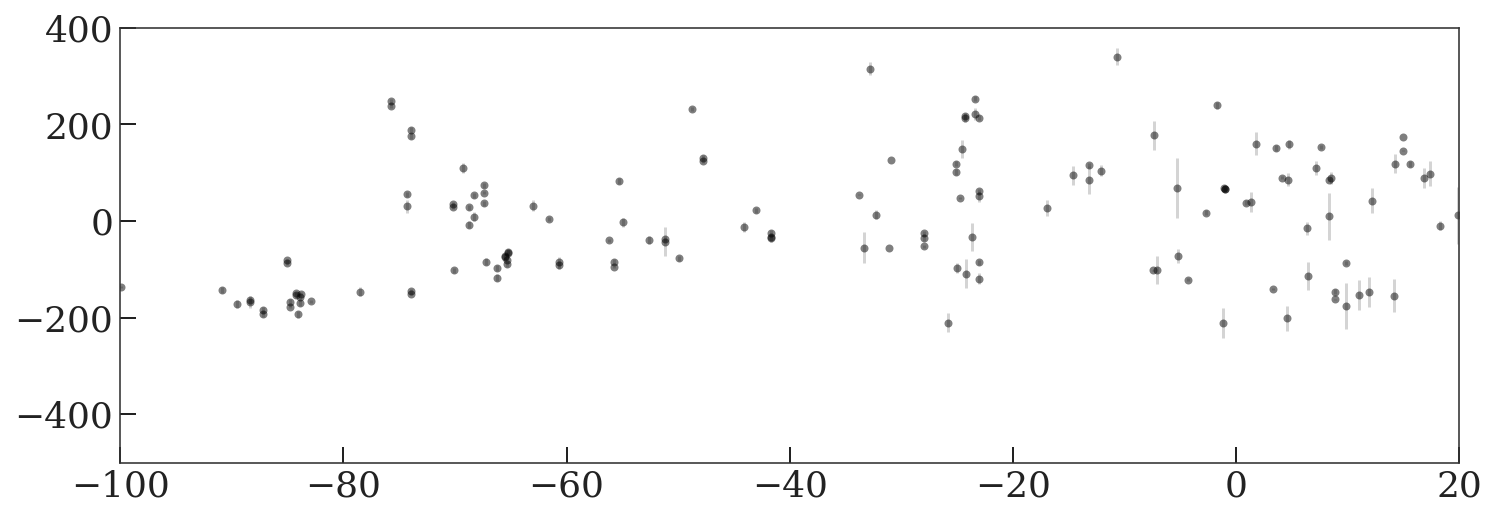

In [90]:
# _strict = (all_stacked['member_prob'] > 0.01)
_strict = (all_stacked['member_prob'] < 0.5)

fig, ax = plt.subplots(figsize=(12, 4))
ax.errorbar(
    all_stacked['gd1_phi1'][_strict],
    all_stacked['v_gsr'][_strict],
    all_stacked['gd1_rv_err'][_strict],
    ls='none',
    marker='o',
    ecolor='#aaaaaa',
    alpha=0.5,
    ms=4
)
ax.set_xlim(-100, 20)
ax.set_ylim(-500, 400)

# RV membership

In [91]:
import pathlib
import pickle

import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import scipy.ndimage as scn
import scipy.interpolate as sci
import scipy.optimize as sco

from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import jax.scipy as jsci
import blackjax

# from gd1_helpers.membership.rv import RVStreamModel, RVBackgroundModel, RVJointModel
from gd1_helpers.membership.rv import RVStreamModel, RVBackgroundModel, RVMixtureModel

In [92]:
data_path = pathlib.Path('../data').resolve().absolute()
cache_path = pathlib.Path('../cache').resolve().absolute()

In [93]:
all_stacked = at.Table.read(data_path / 'gd1-all-spectro-data.fits')
lenient_mask = all_stacked['member_prob'] > 0.1
strict_mask = all_stacked['member_prob'] > 0.8

In [94]:
RVMixtureModel.N_survey = np.unique(all_stacked['survey_id']).size
RVMixtureModel.param_names['rv0'] = RVMixtureModel.N_survey
RVMixtureModel.param_names['ln_extra_err'] = RVMixtureModel.N_survey

In [95]:
with open(cache_path / 'fiducial_rv_spline.pkl', 'rb') as f:
    fiducial_spl = pickle.load(f)

In [96]:
data = {
    'survey_id': all_stacked['survey_id'],
    'phi1': all_stacked['gd1_phi1'],
    # 'rv': all_stacked['gd1_rv'],
    'rv': all_stacked['v_gsr'],
    'rv_error': np.sqrt(all_stacked['gd1_rv_err']**2 + 0.1**2),
}

for k in data:
    if k == 'survey_id':
        data[k] = np.array(data[k], dtype=np.int32, copy=True)
    else:
        data[k] = np.array(data[k], dtype=np.float64, copy=True)
        
    assert np.all(np.isfinite(data[k]))

Text(0.5, 0, '$\\phi_1$')

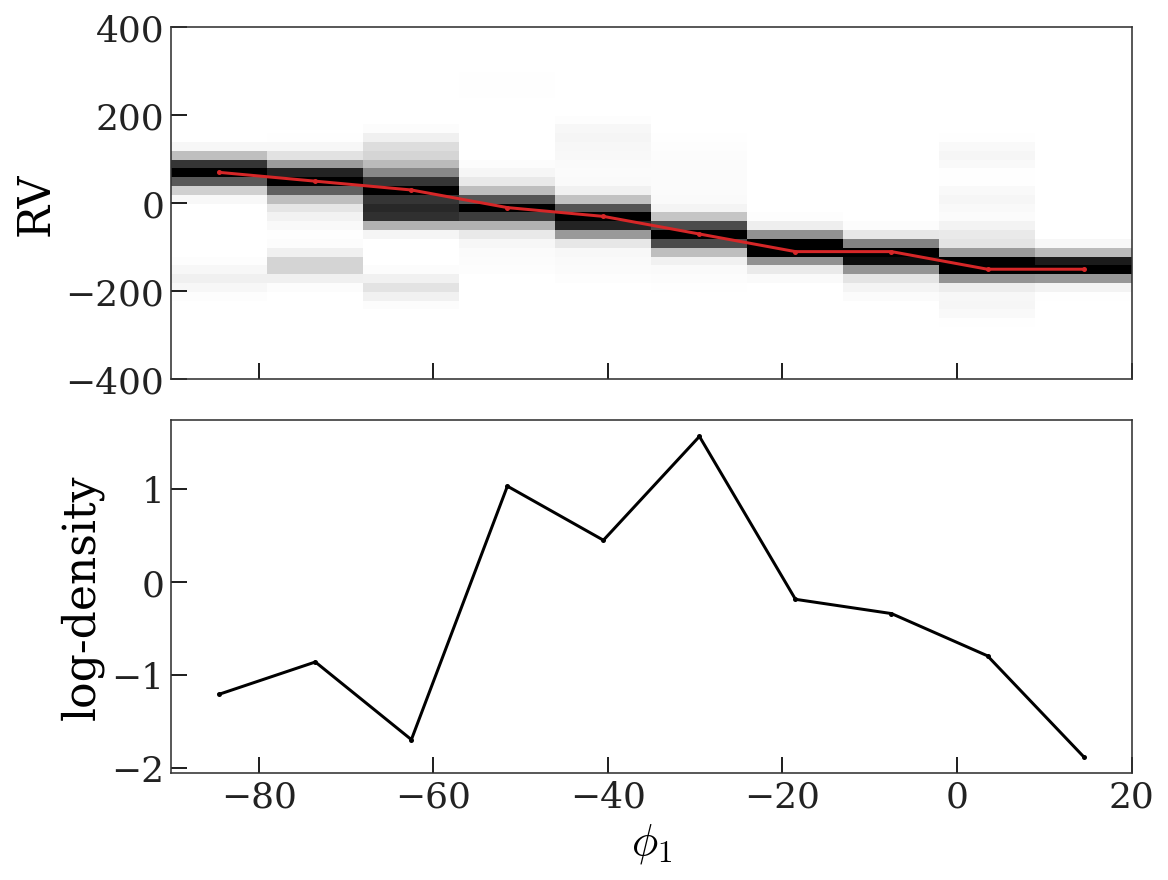

In [97]:
H, xe, ye = np.histogram2d(
    data['phi1'][strict_mask],
    data['rv'][strict_mask],
    bins=(np.linspace(-90, 20 + 1e-3, 11), np.arange(-400, 400 + 1e-3, 20)),
)
xc = 0.5 * (xe[:-1] + xe[1:])
yc = 0.5 * (ye[:-1] + ye[1:])

H = scn.gaussian_filter1d(H, sigma=1)
H /= (xe[1] - xe[0])
H_density = H.copy()

peak_idx = H.argmax(axis=1)
H /= H[np.arange(H.shape[0]), peak_idx][:, None]
H_ln_density = np.log(H_density[np.arange(H.shape[0]), peak_idx])


fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, constrained_layout=True)
cs = axes[0].pcolormesh(xe, ye, H.T, vmin=0, vmax=1, cmap="Greys")
axes[0].plot(xc, yc[peak_idx], color="tab:red")
axes[0].set_ylabel("RV")

axes[1].plot(xc, H_ln_density)
axes[1].set_ylabel(r"log-density")
axes[1].set_xlabel(r"$\phi_1$")

In [98]:
stream_init_p = {}
# stream_init_p['ln_n0'] = sci.InterpolatedUnivariateSpline(xc, H_ln_density, k=1)(RVStreamModel.ln_n0_knots)
stream_init_p['mean'] = sci.InterpolatedUnivariateSpline(xc, yc[peak_idx], k=1)(
    RVStreamModel.rv_knots
)
stream_init_p["ln_std"] = np.full_like(stream_init_p['mean'], -1)
# RVStreamModel.ln_likelihood(stream_init_p, data)

Text(0.5, 0, '$\\phi_1$')

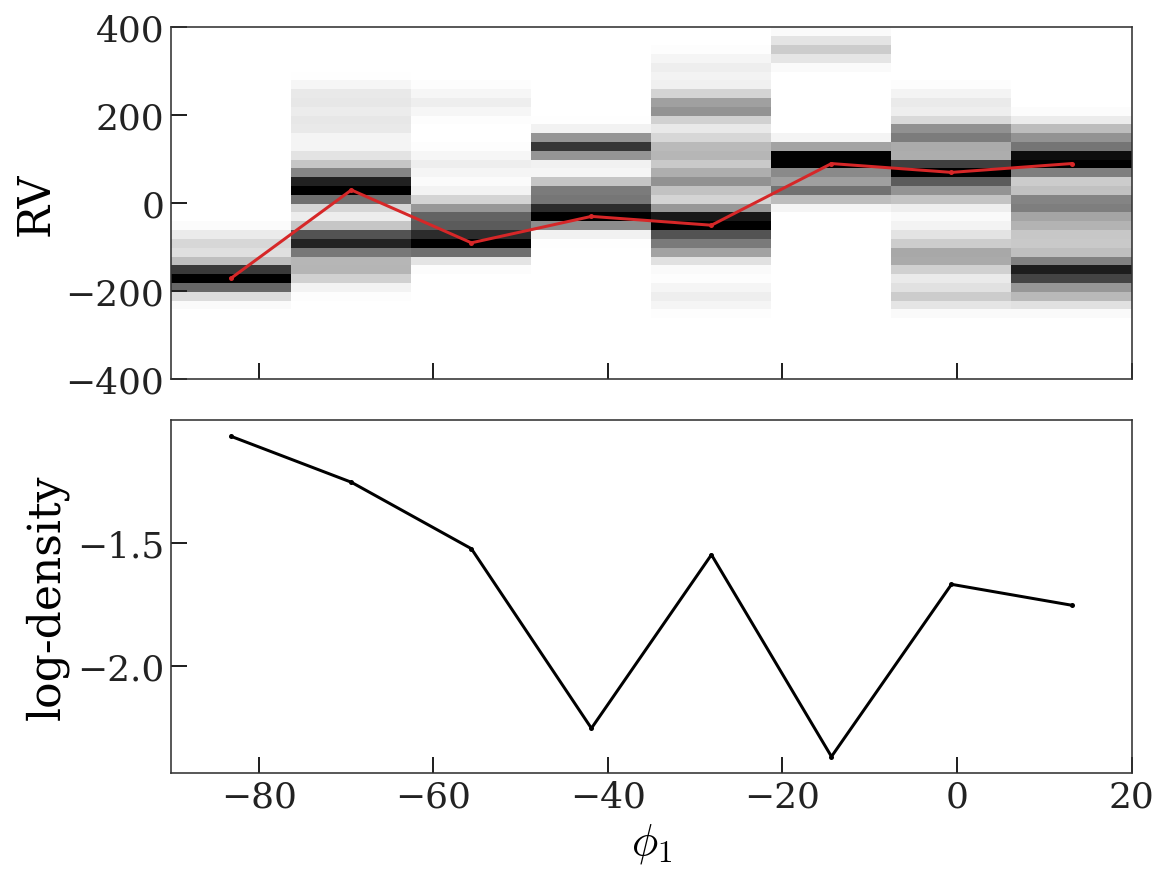

In [99]:
H, xe, ye = np.histogram2d(
    data['phi1'][~strict_mask],
    data['rv'][~strict_mask],
    bins=(np.linspace(-90, 20 + 1e-3, 9), 
          np.arange(-400, 400 + 1e-3, 20)),
)
xc = 0.5 * (xe[:-1] + xe[1:])
yc = 0.5 * (ye[:-1] + ye[1:])

H = scn.gaussian_filter1d(H, sigma=1)
H /= (xe[1] - xe[0])
H_density = H.copy()

peak_idx = H.argmax(axis=1)
H /= H[np.arange(H.shape[0]), peak_idx][:, None]
bg_H_ln_density = np.log(H_density[np.arange(H.shape[0]), peak_idx])


fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, constrained_layout=True)
cs = axes[0].pcolormesh(xe, ye, H.T, vmin=0, vmax=1, cmap="Greys")
axes[0].plot(xc, yc[peak_idx], color="tab:red")
axes[0].set_ylabel("RV")

axes[1].plot(xc, bg_H_ln_density)
axes[1].set_ylabel(r"log-density")
axes[1].set_xlabel(r"$\phi_1$")

In [100]:
bkg_init_p = {}
# bkg_init_p['ln_n0'] = sci.InterpolatedUnivariateSpline(xc, bg_H_ln_density, k=1)(RVBackgroundModel.ln_n0_knots)
# bkg_init_p['ln_n0'] = np.full_like(RVBackgroundModel.ln_n0_knots, stream_init_p['ln_n0'].min() - 1)
bkg_init_p['arctanh_w'] = np.full_like(RVBackgroundModel.rv_knots, 0.)
bkg_init_p['mean1'] = np.full_like(RVBackgroundModel.rv_knots, -180.)
bkg_init_p['mean2'] = np.full_like(RVBackgroundModel.rv_knots, 0.)
bkg_init_p['ln_std1'] = np.full_like(RVBackgroundModel.rv_knots, np.log(25))
bkg_init_p['ln_std2'] = np.full_like(RVBackgroundModel.rv_knots, np.log(100))

# RVBackgroundModel.ln_likelihood(bkg_init_p, data)

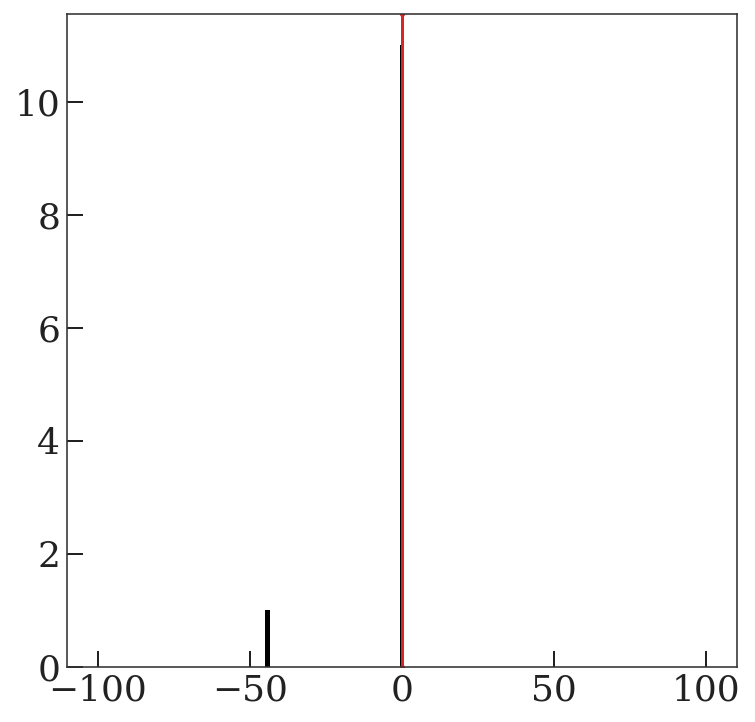

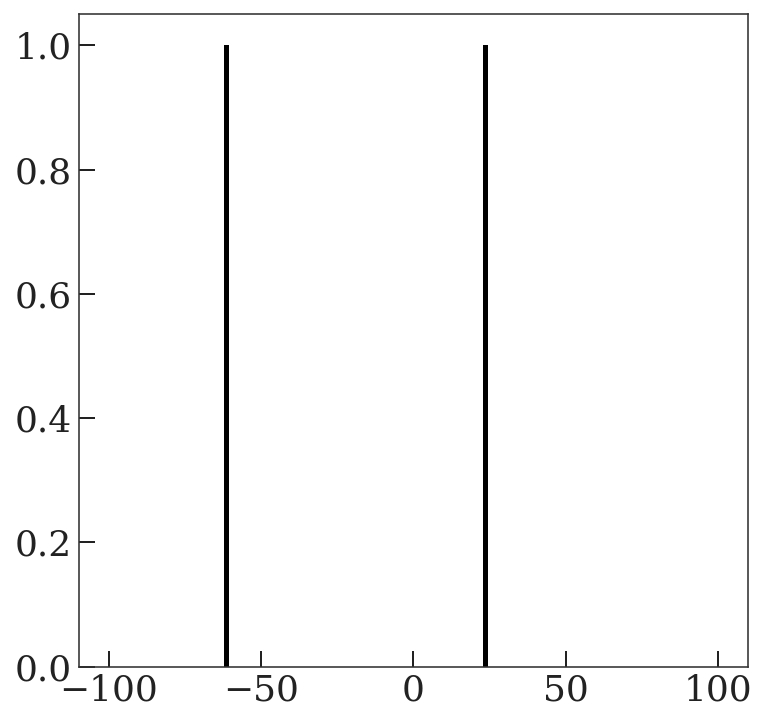

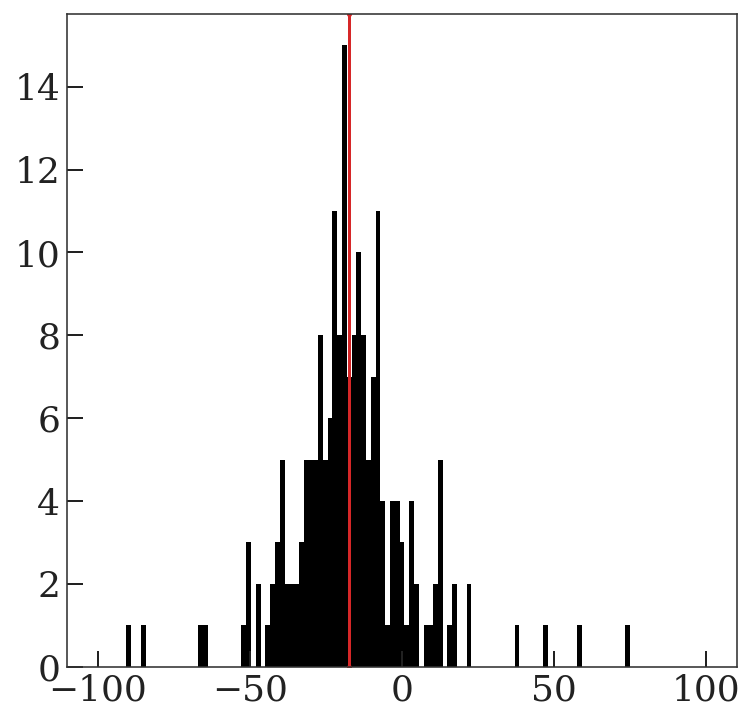

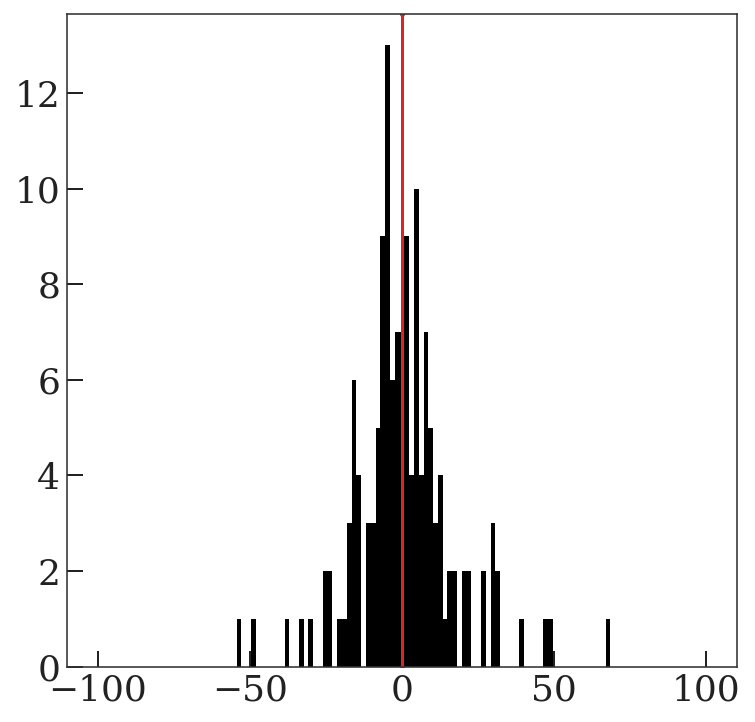

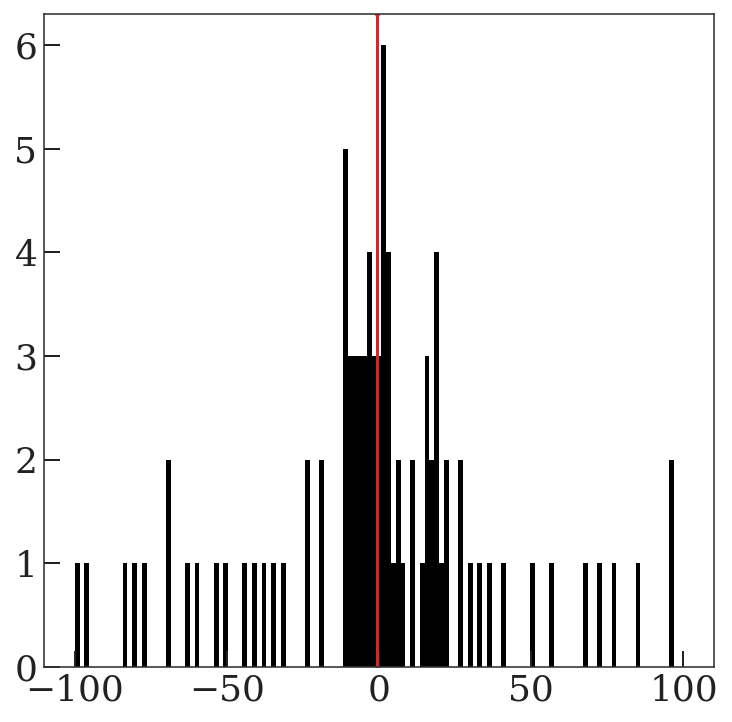

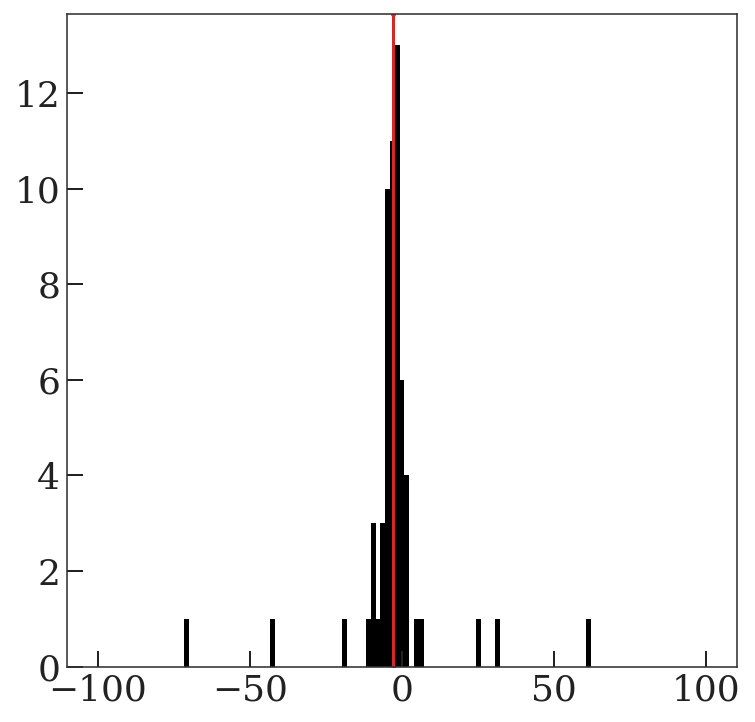

In [101]:
rv0 = np.zeros(np.unique(all_stacked['survey_id']).size)
for i in np.unique(all_stacked['survey_id']):
    _mask = (all_stacked['survey_id'] == i) & (all_stacked['member_prob'] > 0.8)
    drv = all_stacked['gd1_rv'][_mask] - fiducial_spl(all_stacked['gd1_phi1'][_mask])
    plt.figure()
    plt.hist(drv,
             bins=np.linspace(-100, 100, 128))
    if len(drv) > 10:
        rv0[i] = np.median(drv)
        plt.axvline(np.median(drv), color='tab:red')

In [102]:
offset_init_p = {'rv0': -rv0}
print(rv0)
# RVOffsetModel.ln_likelihood(stream_init_p, data)

[  0.           0.         -17.50317608   0.09894786  -0.73548277
  -2.92310586]


In [103]:
# for i in range(len(rv0)):
#     _mask = data['survey_id'] == i
#     data['rv'][_mask] = data['rv'][_mask] - rv0[i]

(-500.0, 500.0)

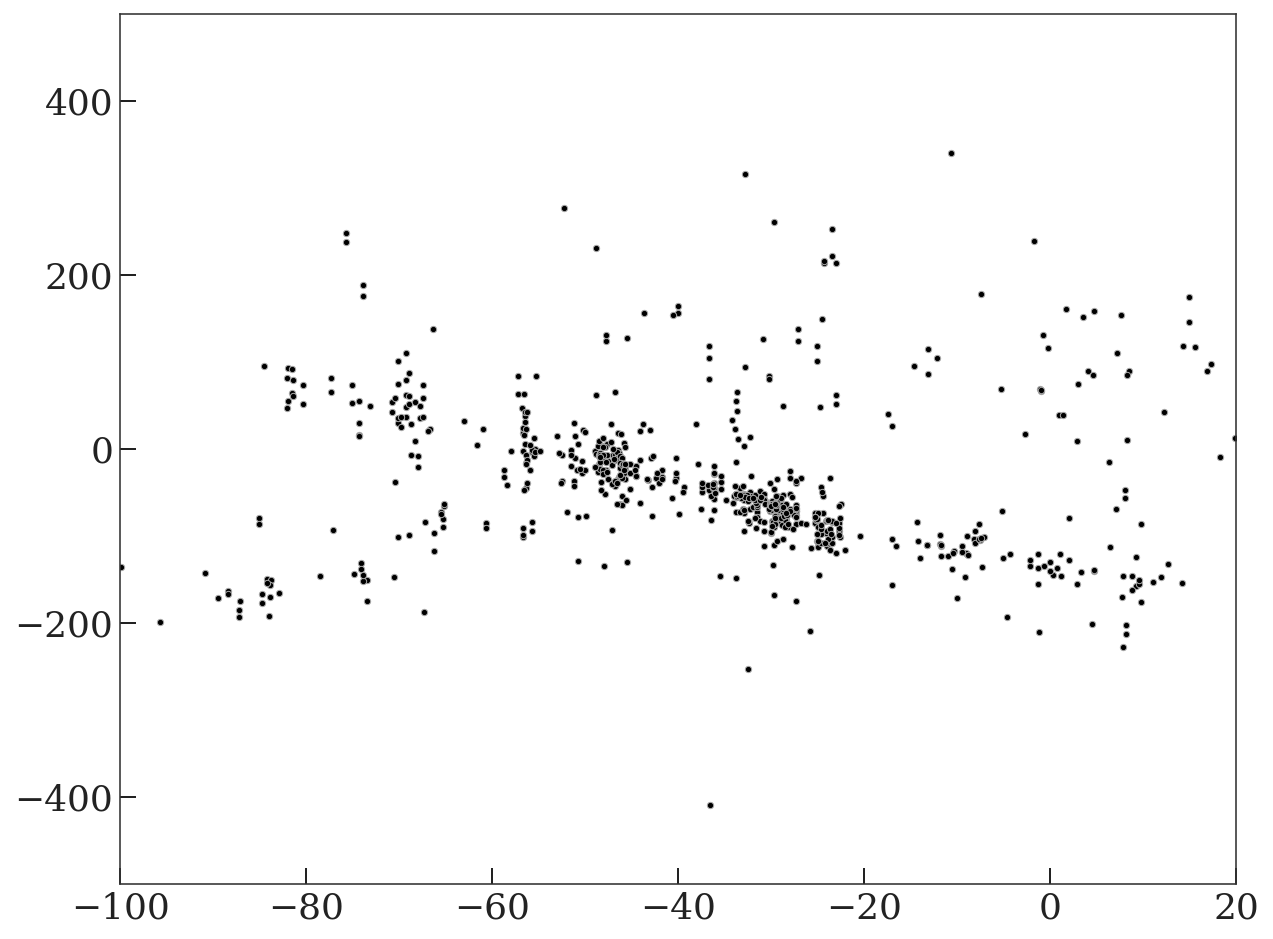

In [104]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(
    data['phi1'],
    data['rv'],
    vmin=0, 
    vmax=1,
    s=10,
    linewidth=0.5, edgecolor='#aaaaaa'
)
ax.set_xlim(-100, 20)
ax.set_ylim(-500, 500)

In [105]:
# rv0 = np.zeros(np.unique(all_stacked['survey_id']).size)
# for i in np.unique(all_stacked['survey_id']):
#     _mask = (all_stacked['survey_id'] == i) & (all_stacked['member_prob'] > 0.8)
#     drv = data['rv'][_mask] - fiducial_spl(data['phi1'][_mask])
#     plt.figure()
#     plt.hist(drv,
#              bins=np.linspace(-100, 100, 128))
#     if len(drv) > 10:
#         rv0[i] = np.median(drv)
#         plt.axvline(np.median(drv), color='tab:red')

In [106]:
init_pars = {
    RVStreamModel.name: stream_init_p, 
    RVBackgroundModel.name: bkg_init_p,
#     RVOffsetModel.name: offset_init_p
    'arctanh_w_mix': np.full_like(RVMixtureModel.w_mix_knots, 0.),
    'rv0': rv0,
    'ln_extra_err': np.full_like(rv0, -1)
}

# flat_init_pars = RVJointModel.pack_component_pars(init_pars)
# flat_init_p = RVJointModel.pack_pars(flat_init_pars)
flat_init_pars = RVMixtureModel.pack_component_pars(init_pars)
flat_init_p = RVMixtureModel.pack_pars(flat_init_pars)
flat_init_p.size

66

In [107]:
# RVMixtureModel.ln_likelihood(flat_init_pars, data)

In [108]:
# RVMixtureModel.ln_prior(flat_init_pars)

In [109]:
RVMixtureModel.objective(flat_init_p, len(data['phi1']), data)

DeviceArray(6.02492864, dtype=float64)

In [110]:
param_bounds = {}
for Component in RVMixtureModel.components.values():
    for k, v in Component.param_bounds.items():
        param_bounds[f'{k}_{Component.name}'] = v
param_bounds.update(RVMixtureModel.param_bounds)

_tmp_l = RVMixtureModel.pack_pars(
    {k: np.full(RVMixtureModel.param_names[k], v[0], dtype='f8') 
     for k, v in param_bounds.items() if k in RVMixtureModel.param_names}
)
_tmp_r = RVMixtureModel.pack_pars(
    {k: np.full(RVMixtureModel.param_names[k], v[1], dtype='f8')
    for k, v in param_bounds.items() if k in RVMixtureModel.param_names}
)
bounds = np.stack((_tmp_l, _tmp_r)).T
assert bounds.shape[0] == flat_init_p.shape[0]

Check that all initial paramter values are in bounds

In [111]:
flat_init_pars

{'arctanh_w_background': DeviceArray([0., 0., 0., 0., 0., 0., 0.], dtype=float64),
 'arctanh_w_mix': DeviceArray([0., 0., 0., 0., 0.], dtype=float64),
 'ln_extra_err': DeviceArray([-1., -1., -1., -1., -1., -1.], dtype=float64),
 'ln_std1_background': DeviceArray([3.21887582, 3.21887582, 3.21887582, 3.21887582, 3.21887582,
              3.21887582, 3.21887582], dtype=float64),
 'ln_std2_background': DeviceArray([4.60517019, 4.60517019, 4.60517019, 4.60517019, 4.60517019,
              4.60517019, 4.60517019], dtype=float64),
 'ln_std_stream': DeviceArray([-1., -1., -1., -1., -1., -1., -1.], dtype=float64),
 'mean1_background': DeviceArray([-180., -180., -180., -180., -180., -180., -180.], dtype=float64),
 'mean2_background': DeviceArray([0., 0., 0., 0., 0., 0., 0.], dtype=float64),
 'mean_stream': DeviceArray([ 116.36330579,   73.93944904,   31.51559228,  -31.81652894,
              -110.        , -150.        , -150.        ], dtype=float64),
 'rv0': DeviceArray([  0.        ,   0.    

In [112]:
for k in RVMixtureModel.param_names:
    check = (
        (flat_init_pars[k] >= param_bounds[k][0]) &
        (flat_init_pars[k] <= param_bounds[k][1])
    )
    if not np.all(check):
        print(k, flat_init_pars[k])

## Run optimizer

In [113]:
obj_grad = jax.jit(jax.grad(RVMixtureModel.objective))
run_res = sco.minimize(
    RVMixtureModel.objective, 
    x0=np.array(flat_init_p, dtype=np.float64),
    jac=lambda x, *args: np.array(obj_grad(x, *args), dtype=np.float64),
    method='l-bfgs-b',
    bounds=bounds,
    args=(len(data['phi1']), data),
    options=dict(maxiter=100_000, maxls=1000)
)
assert run_res.success
run_res


# obj_grad = jax.jit(jax.grad(RVMixtureModel.objective))
# def _jac(x, *args):
#     print(list(np.array(x)))
#     return np.array(obj_grad(x, *args), dtype=np.float64)
    
# run_res = sco.minimize(
#     RVMixtureModel.objective, 
#     x0=np.array(flat_init_p, dtype=np.float64),
#     jac=_jac,
#     method='l-bfgs-b',
#     bounds=bounds,
#     args=(len(data['phi1']), data),
#     options=dict(maxiter=100_000, maxls=1000)
# )
# run_res

      fun: 5.215850952357598
 hess_inv: <66x66 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.63089429e-06,  6.31747318e-06,  2.80727436e-05, -8.97680971e-06,
       -1.85195842e-06, -5.36823576e-06, -3.19731450e-07,  3.99080446e-06,
       -1.86175235e-06, -1.16305586e-07,  8.21069625e-06,  4.82093627e-08,
       -6.84415451e-07, -8.61311364e-06, -8.22947906e-05, -1.26863959e-06,
        9.81802771e-07,  2.84509003e-06,  2.65534082e-05, -6.86092873e-06,
        1.22425649e-05,  7.18251630e-06,  1.77237619e-06,  1.70365112e-06,
       -4.08841663e-06, -5.61252517e-07, -6.67964517e-05, -1.16029217e-06,
        5.62111831e-07, -8.47323232e-06,  3.21854201e-07, -6.11004261e-07,
       -7.42111258e-07,  8.44069712e-07,  5.09805343e-06, -2.55773469e-07,
        1.08161633e-06, -4.94091181e-07, -5.73753518e-06, -3.28962283e-06,
       -5.61228892e-06,  1.01241282e-05, -2.26488351e-05,  9.10384788e-06,
        4.34555918e-06, -2.12560537e-06,  3.11671733e-06,  8.32159516e-05,
  

In [114]:
opt_pars = RVMixtureModel.unpack_component_pars(RVMixtureModel.unpack_pars(run_res.x))

# fail_x = np.array([-0.02957507124301449, 1.4379779684012397, 0.48425230712179645, -0.03769325791841171, 0.8482712558751321, 0.056560328007213, -1.3308073410202688, -0.42179330807362003, 1.3392809621257786, -0.7975743652117689, -1.1362218812025673, -0.05620263014189426, -4.559306184835488e-05, 0.002032678875560345, 0.03496993567174979, -0.06881831530472546, -0.04640718504980975, 0.009008357015544241, -6.720419972995847e-05, -0.0003098377943080572, -0.008633980100916153, -0.0002419939848562444, -0.0020122638366151372, -0.003837321845543841, 0.00498985858344022, 0.000796393686284305, 3.217608661739025, 3.6556313589317515, 3.85048695155093, 3.5118820005548743, 5.0, 3.393765031996945, 3.255689887758782, 4.725047988475092, 4.8668343436416315, 4.960925323683192, 5.561128785178868, 5.1972996335726185, 4.859357545327325, 4.724584323447197, 116.35954841316453, 52.842504629107545, -31.479246512240895, -119.394420399174, -150.00452032674926])
# opt_pars = RVMixtureModel.unpack_component_pars(RVMixtureModel.unpack_pars(fail_x))

In [115]:
# shit = RVMixtureModel.ln_likelihood(RVMixtureModel.unpack_pars(fail_x), data)

(-500.0, 500.0)

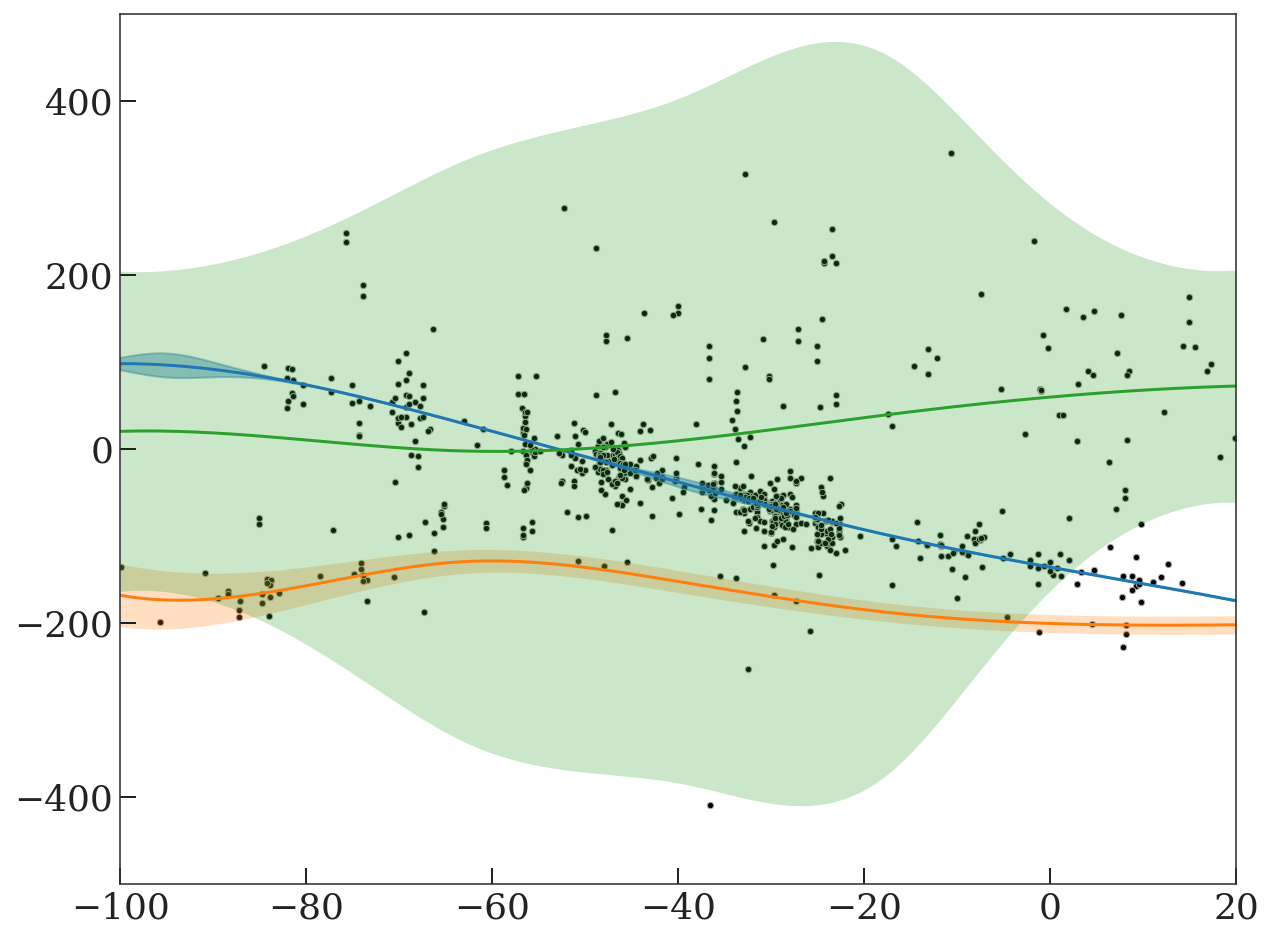

In [116]:
phi1_grid = np.linspace(-100, 20, 256)

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(
    data['phi1'],
    data['rv'],
    vmin=0, 
    vmax=1,
    s=10,
    linewidth=0.5, edgecolor='#aaaaaa'
)

# Stream
tmp_mean = sci.InterpolatedUnivariateSpline(
    RVStreamModel.rv_knots,
    opt_pars['stream']['mean'],
    k=3
)
tmp_ln_std = sci.InterpolatedUnivariateSpline(
    RVStreamModel.rv_knots,
    opt_pars['stream']['ln_std'],
    k=3
)
tmp_std = np.exp(tmp_ln_std(phi1_grid))
ax.plot(phi1_grid, tmp_mean(phi1_grid), marker='', color='tab:blue')
ax.fill_between(
    phi1_grid, 
    tmp_mean(phi1_grid) - 2*tmp_std,
    tmp_mean(phi1_grid) + 2*tmp_std,
    alpha=0.4,
    color='tab:blue'
)

# BG
for i, color in zip([1, 2], ['tab:orange', 'tab:green']):
    tmp_mean = sci.InterpolatedUnivariateSpline(
        RVBackgroundModel.rv_knots,
        opt_pars['background'][f'mean{i}'],
        k=3
    )
    tmp_ln_std = sci.InterpolatedUnivariateSpline(
        RVStreamModel.rv_knots,
        opt_pars['background'][f'ln_std{i}'],
        k=3
    )
    tmp_std = np.exp(tmp_ln_std(phi1_grid))
    ax.plot(phi1_grid, tmp_mean(phi1_grid), marker='', color=color)
    ax.fill_between(
        phi1_grid, 
        tmp_mean(phi1_grid) - 2*tmp_std,
        tmp_mean(phi1_grid) + 2*tmp_std,
        alpha=0.25,
        linewidth=0,
        color=color
    )

ax.set_xlim(-100, 20)
ax.set_ylim(-500, 500)

In [117]:
opt_pars['stream']

{'ln_std': DeviceArray([-5.        ,  0.67835431, -5.        ,  1.        ,
              -3.87928576, -5.        ,  1.        ], dtype=float64),
 'mean': DeviceArray([  89.46354986,   86.35821062,   29.72199273,  -38.22349836,
              -101.14775713, -148.79620355, -197.02418515], dtype=float64)}

In [118]:
opt_pars['background']

{'arctanh_w': DeviceArray([ 0.052964  ,  0.95790673, -1.27781856, -1.52819782,
              -1.35335753, -1.09368481, -0.23059518], dtype=float64),
 'ln_std1': DeviceArray([2.84673272, 2.59484251, 1.92051426, 1.84816563, 1.67860125,
              1.64505716, 1.64169275], dtype=float64),
 'ln_std2': DeviceArray([4.70784932, 4.62891398, 5.11449158, 5.2816574 , 5.315938  ,
              4.44453387, 4.51956211], dtype=float64),
 'mean1': DeviceArray([-130.        , -169.0563317 , -130.        , -152.69445007,
              -189.11575491, -202.52349706, -200.93825885], dtype=float64),
 'mean2': DeviceArray([ 9.86972818, 15.89610156, -2.52759691,  9.12018693,
              40.23832957, 65.02226559, 73.05220113], dtype=float64)}

In [119]:
opt_pars['arctanh_w_mix']

DeviceArray([ 0.12655127,  0.45082338, -0.68057635, -0.74905959,
              0.27014348], dtype=float64)

In [120]:
opt_pars['rv0']

DeviceArray([  3.6667043 ,   0.38847115, -11.03769622,   4.92466415,
               0.98224979,   2.30914938], dtype=float64)

In [121]:
np.exp(opt_pars['ln_extra_err'])

array([9.39899268e-03, 1.08381274e+00, 1.06074054e+01, 1.17342550e+01,
       3.54912088e+01, 2.33894463e+00])

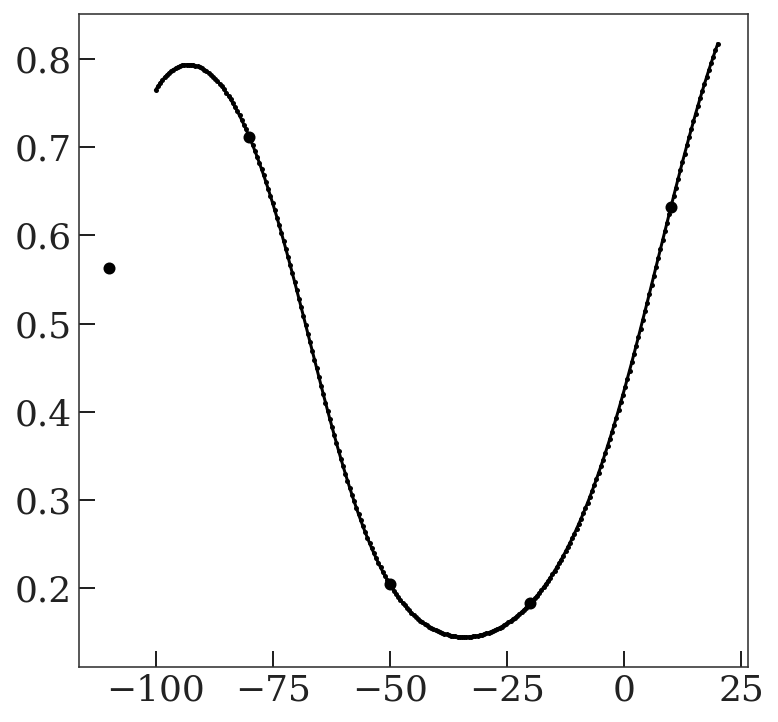

In [122]:
tmp = sci.InterpolatedUnivariateSpline(
    RVMixtureModel.w_mix_knots,
    opt_pars['arctanh_w_mix'],
    k=3
)

_grid = np.linspace(-100, 20, 256)
tmp_w = (np.tanh(tmp(_grid)) + 1) / 2

plt.plot(_grid, tmp_w)
plt.scatter(RVMixtureModel.w_mix_knots, (np.tanh(opt_pars['arctanh_w_mix']) + 1) / 2)

In [123]:
# opt_pars['offset']

In [124]:
proc_data = RVMixtureModel.preprocess_data(opt_pars, data)
ll_bg = RVBackgroundModel.ln_likelihood(opt_pars['background'], proc_data)
ll_fg = RVStreamModel.ln_likelihood(opt_pars['stream'], proc_data)
post_prob = np.exp(ll_fg - np.logaddexp(ll_fg, ll_bg))

(-500.0, 400.0)

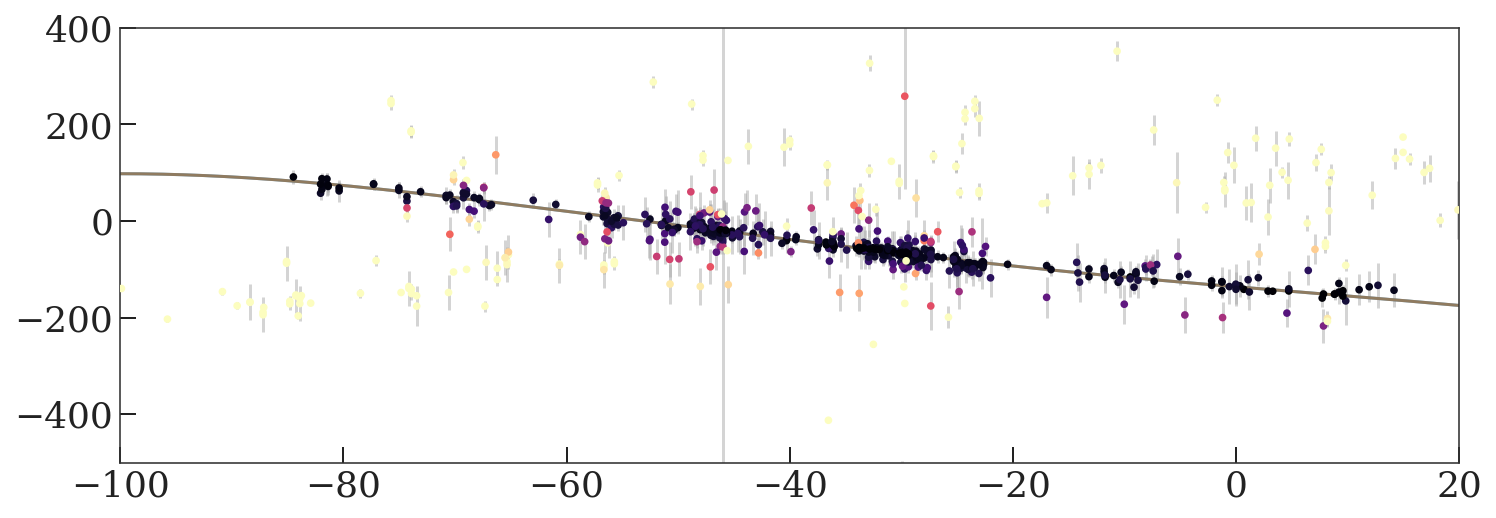

In [125]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.errorbar(
    proc_data['phi1'],
    proc_data['rv'],
    proc_data['rv_error'],
    ls='none',
    marker='',
    ecolor='#aaaaaa',
    alpha=0.5,
    ms=4,
    zorder=1
)
ax.scatter(
    proc_data['phi1'],
    proc_data['rv'],
    c=post_prob,
    vmin=0,
    vmax=1,
    cmap='magma_r',
    zorder=10,
    s=8
)

_grid = np.linspace(-100, 20, 256)
mean_spl = sci.InterpolatedUnivariateSpline(RVStreamModel.rv_knots, opt_pars['stream']['mean'], k=3)
# ln_std_spl = sci.InterpolatedUnivariateSpline(RVStreamModel.rv_knots, opt_pars['stream']['ln_std_rv'], k=3)
# tmp_std = np.exp(ln_std_spl(_grid))
tmp_std = 0.
ax.plot(
    _grid, 
    mean_spl(_grid),
    marker=''
)
ax.plot(
    _grid, 
    mean_spl(_grid) + tmp_std,
    marker='',
    alpha=0.5
)

ax.set_xlim(-100, 20)
ax.set_ylim(-500, 400)

507


(-7.0, 5.0)

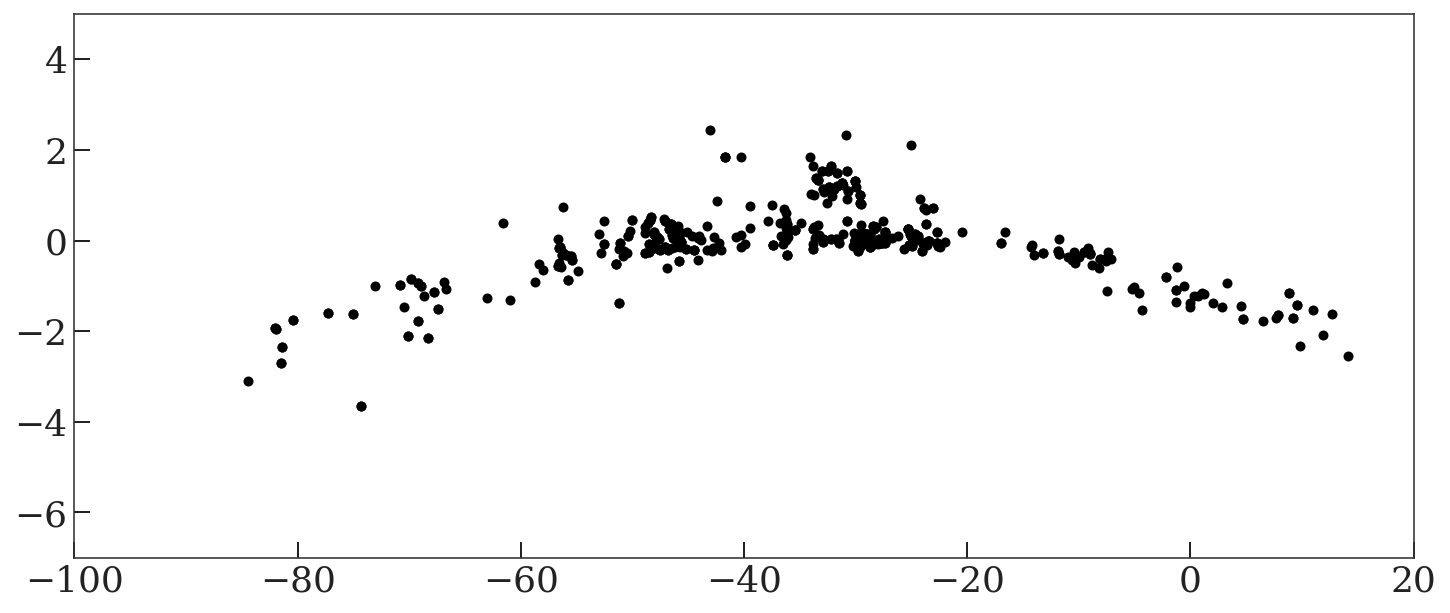

In [126]:
prob_mask = post_prob > 0.5
print(prob_mask.sum())

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(
    all_stacked['gd1_phi1'][prob_mask],
    all_stacked['gd1_phi2'][prob_mask],
    marker='o',
    ls='none'
)
ax.set_xlim(-100, 20)
ax.set_ylim(-7, 5)

In [127]:
tbl = all_stacked['source_id', 'gd1_rv', 'gd1_rv_err', 'v_gsr']
tbl['rv_member_prob'] = post_prob
tbl.write(cache_path / 'optimized-member-prob-rv.fits', overwrite=True)

In [128]:
with open(cache_path / 'rv-vgsr-stream-model.pkl', 'wb') as f:
    pickle.dump((RVStreamModel, opt_pars['stream']), f)

---

In [1]:
import numpyro.distributions as dist
def rv_model(data):
    rv_knots = jnp.arange(-100, 20+1, 20)
    
    mean = dist.Uniform("mean", -300, 300, shape=)
    ln_std = dist.Uniform("ln_std", -5, 2, shape=)
    
    mean_spl = InterpolatedUnivariateSpline(rv_knots, mean)
    ln_std_spl = InterpolatedUnivariateSpline(rv_knots, ln_std)
    
    norm = dist.Normal(
        mean_spl(data['phi1']), 
        jnp.sqrt(jnp.exp(2 * ln_std_spl(data['phi1'])) + data['rv_err']**2),
        obs=data['rv']
    )